In [25]:
%matplotlib inline

In [26]:
# Loading libraries
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset

In [27]:
# Loading the dataset
dataset = load_dataset("stanfordnlp/sst2")
test_data = dataset["validation"]
N = int(input("Enter the number of texts for testing: "))
texts  = test_data["sentence"][:N]
labels = test_data["label"][:N]
print("Loaded", len(texts), "test samples")

Enter the number of texts for testing: 50
Loaded 50 test samples


In [28]:
# Calculating TOPSIS Value
def TOPSIS(matrix, weights, impacts):
    matrix = matrix / np.sqrt((matrix ** 2).sum(axis = 0))
    matrix = matrix * weights
    ideal_best = []
    ideal_worst = []

    for i in range(len(impacts)):
        if impacts[i] == "+":
            ideal_best.append(matrix[:, i].max())
            ideal_worst.append(matrix[:, i].min())
        else:
            ideal_best.append(matrix[:, i].min())
            ideal_worst.append(matrix[:, i].max())

    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)

    d_best = np.sqrt(((matrix - ideal_best) ** 2).sum(axis = 1))
    d_worst = np.sqrt(((matrix - ideal_worst) ** 2).sum(axis = 1))

    scores = d_worst / (d_best + d_worst)
    best_index = np.argmax(scores)

    return best_index, scores

In [29]:
# Evaluating the models
models = ["distilbert/distilbert-base-uncased-finetuned-sst-2-english",
            "ProsusAI/finbert",
            "BAAI/bge-reranker-v2-m3",
            "oeg/RoBERTaSense-FACIL",
            "NousResearch/Minos-v1"]
results = []
for model_name in models:
    print("\nEvaluating:", model_name)
    clf = pipeline("text-classification", model = model_name)
    start = time.time()
    preds = clf(texts)
    elapsed = time.time() - start

    y_pred = [1 if p["label"] == "POSITIVE" else 0 for p in preds]
    confidences = [p["score"] for p in preds]
    acc = accuracy_score(labels, y_pred)
    f1  = f1_score(labels, y_pred)
    avg_conf = np.mean(confidences)

    print(f"Accuracy        = {acc:.3f}")
    print(f"F1 Score        = {f1:.3f}")
    print(f"Avg Confidence  = {avg_conf:.3f}")
    print(f"Inference Time  = {elapsed:.2f} sec")
    results.append([acc, f1, avg_conf, elapsed])


Evaluating: distilbert/distilbert-base-uncased-finetuned-sst-2-english


Device set to use cpu


Accuracy        = 0.980
F1 Score        = 0.980
Avg Confidence  = 0.994
Inference Time  = 14.20 sec

Evaluating: ProsusAI/finbert


Device set to use cpu


Accuracy        = 0.520
F1 Score        = 0.000
Avg Confidence  = 0.783
Inference Time  = 13.46 sec

Evaluating: BAAI/bge-reranker-v2-m3


Device set to use cpu


Accuracy        = 0.520
F1 Score        = 0.000
Avg Confidence  = 0.056
Inference Time  = 51.49 sec

Evaluating: oeg/RoBERTaSense-FACIL


Device set to use cpu


Accuracy        = 0.520
F1 Score        = 0.000
Avg Confidence  = 0.574
Inference Time  = 12.86 sec

Evaluating: NousResearch/Minos-v1


Device set to use cpu


Accuracy        = 0.520
F1 Score        = 0.000
Avg Confidence  = 0.974
Inference Time  = 42.73 sec


In [30]:
# Applying TOPSIS
decision_matrix = np.array(results)
weights = [1, 1, 1, 1]
impacts = ["+", "+", "+", "-"]
best_idx, scores = TOPSIS(decision_matrix, weights, impacts)
print("TOPSIS Scores:", scores)
print("Best Model:", models[best_idx])

TOPSIS Scores: [0.98566308 0.39349719 0.         0.36659941 0.32874049]
Best Model: distilbert/distilbert-base-uncased-finetuned-sst-2-english


In [31]:
# Creation of Table
df = pd.DataFrame(results, columns=[
    "Accuracy",
    "F1 Score",
    "Avg Confidence",
    "Inference Time"
])
df["Model"] = ["Distilbert", "Finbert", "BAAI", "Facil", "Minos"]
df["TOPSIS Score"] = scores

df = df[["Model", "Accuracy", "F1 Score", "Avg Confidence", "Inference Time", "TOPSIS Score"]]
print("\nFinal Results Table:\n")
print(df)


Final Results Table:

        Model  Accuracy  F1 Score  Avg Confidence  Inference Time  \
0  Distilbert      0.98  0.979592        0.994439       14.195855   
1     Finbert      0.52  0.000000        0.783030       13.458172   
2        BAAI      0.52  0.000000        0.056110       51.491604   
3       Facil      0.52  0.000000        0.574426       12.857078   
4       Minos      0.52  0.000000        0.973776       42.731398   

   TOPSIS Score  
0      0.985663  
1      0.393497  
2      0.000000  
3      0.366599  
4      0.328740  


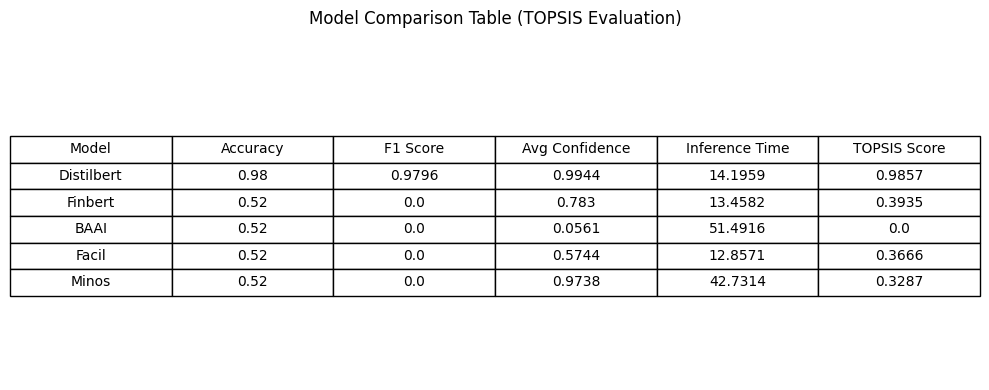

In [32]:
# Table Display
plt.figure(figsize = (10, 4))
plt.axis('off')
df_rounded = df.round(4)

table = plt.table(
    cellText = df_rounded.values,
    colLabels = df.columns,
    loc = 'center',
    cellLoc = 'center'
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Model Comparison Table (TOPSIS Evaluation)", pad = 20)
plt.tight_layout()

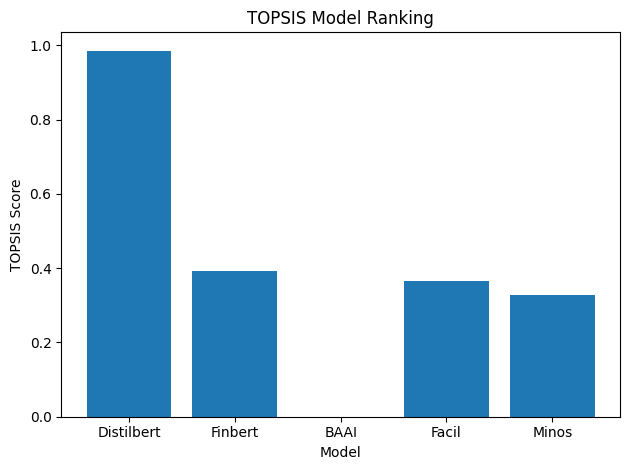

In [33]:
# Topsis Graph
plt.figure()
plt.bar(df["Model"], df["TOPSIS Score"])
plt.title("TOPSIS Model Ranking")
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.tight_layout()
plt.show()

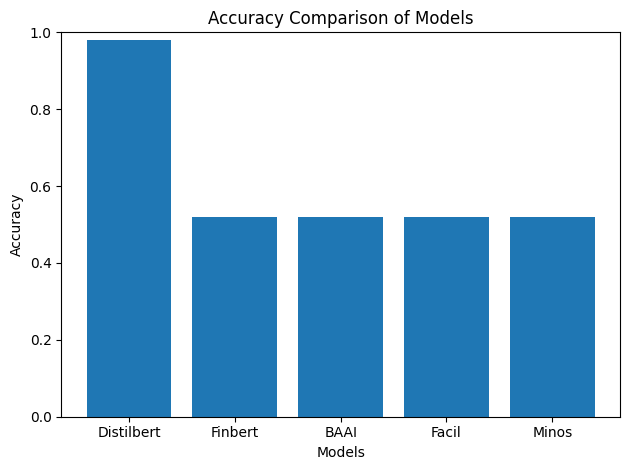

In [34]:
# Accuracy Graph
plt.figure()
plt.bar(df["Model"], df["Accuracy"])
plt.title("Accuracy Comparison of Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()